### Preporcessing
---
#### Step 1: Import all libraries and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from KDD_2Modeling import *
#from KDD_3Prediction import *
#from KDD_4Visualization import *
#from KDD_5Evaluation import *

#### Step2: read csv file

In [2]:
df = pd.read_csv("../data/hour.csv")
print("number of instances: ", df.shape[0])

number of instances:  17379


check the data structure

In [3]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Step 3: Check for missing values and filter them out

In [4]:
missing_values = df.isnull().any(axis=1)
df3 = df[~missing_values]

print("number of instances: ", df3.shape[0])

number of instances:  17379


#### Step 4: Handling duplicate data


In [5]:
duplicates = df3.duplicated()
df4 = df3[~duplicates]

print("number of instances: ", df4.shape[0])

number of instances:  17379


#### Step 5: Data Quality Assurance and Outlier Handling 
Check for Invalid Data and Outliers using Interquartile Range (IQR), and Remove Corresponding Rows

In [6]:
df5 = df4.copy()

valid_season = [1, 2, 3, 4]
valid_month = list(range(1, 13))
valid_hour = list(range(24))
valid_holiday = [0, 1]
valid_weekday = list(range(7))
valid_workingday = [0, 1]
valid_weathersit = [1, 2, 3, 4]

df5 = df5[df5['season'].isin(valid_season)]
df5 = df5[df5['mnth'].isin(valid_month)]
df5 = df5[df5['hr'].isin(valid_hour)]
df5 = df5[df5['holiday'].isin(valid_holiday)]
df5 = df5[df5['weekday'].isin(valid_weekday)]
df5 = df5[df5['workingday'].isin(valid_workingday)]
df5 = df5[df5['weathersit'].isin(valid_weathersit)]

attributes = ['temp', 'hum', 'windspeed', 'cnt']

# Calculate the quantiles and IQR
Q1 = df5[attributes].quantile(0.25, numeric_only=True)
Q3 = df5[attributes].quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection for selected columns
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame by removing rows with values outside the bounds for selected columns
df5 = df5[~((df5[attributes] < lower_bound) | (df5[attributes] > upper_bound)).any(axis=1)]

print("number of instances: ", df5.shape[0])

number of instances:  16522


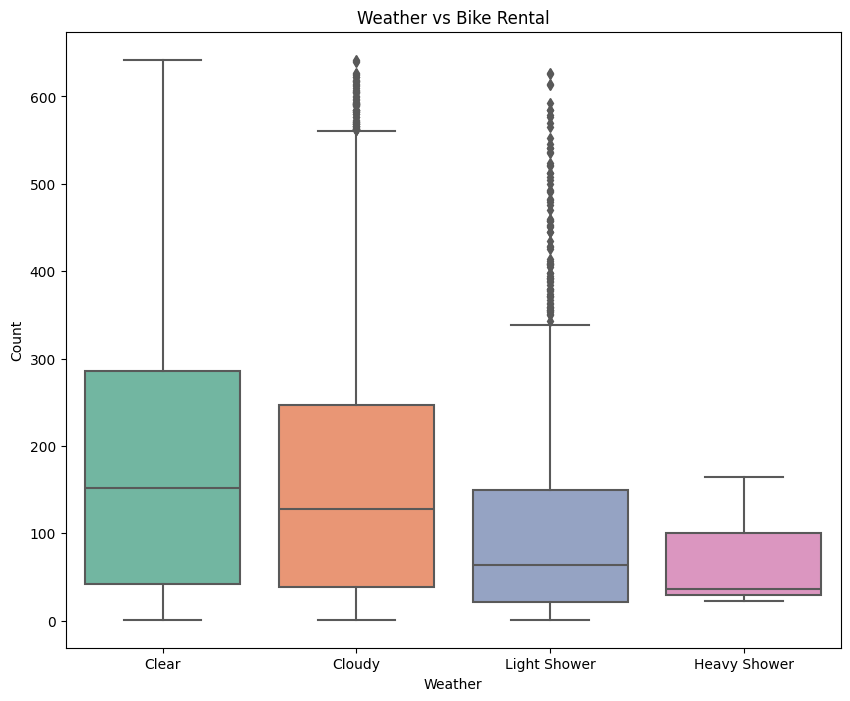

In [7]:
 # Visualizing Weather situation vs bike rentals.
plt.figure(figsize=(10, 8))
sns.boxplot(x='weathersit', y='cnt', data=df5, palette='Set2')
plt.title('Weather vs Bike Rental')
plt.xlabel('Weather')
plt.xticks(np.arange(4), ('Clear', 'Cloudy', 'Light Shower', 'Heavy Shower' ))
plt.ylabel('Count')
plt.show()

#### Step 6: Visualizing and exploring the data for better understanding </br>

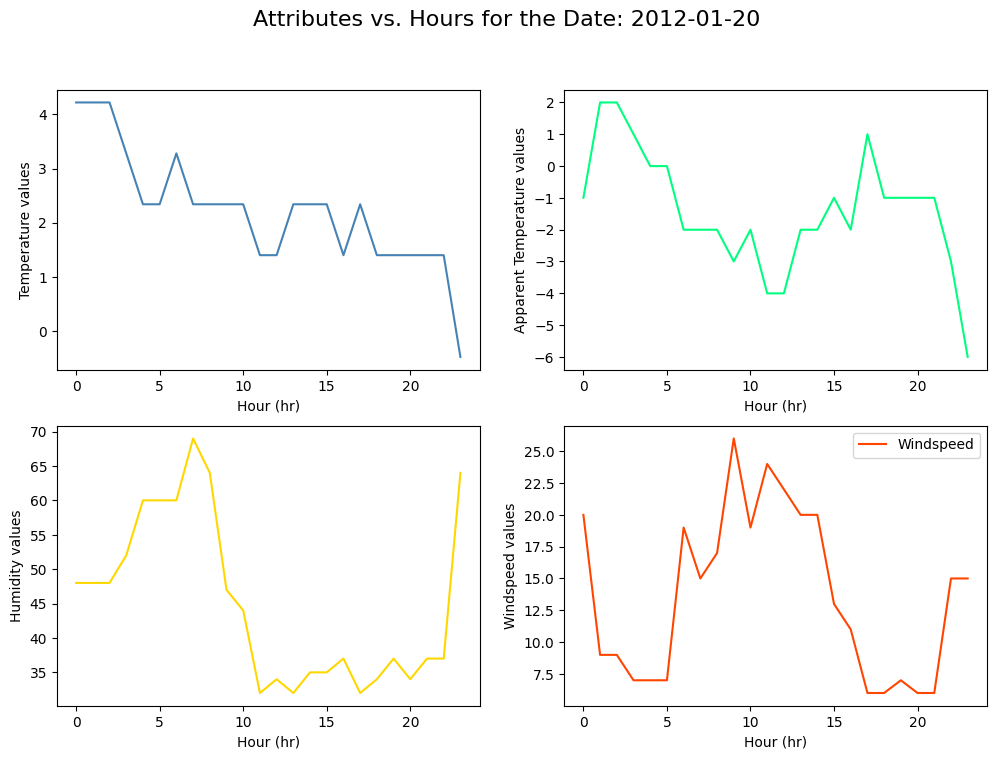

In [8]:
import random
from scipy.signal import savgol_filter


df6 = df5.copy()  # Make a copy of the DataFrame to avoid modifying the original

# Updating attributes to original values
df6['atemp'] = df5['atemp'] * (50 + 16) - 16
df6['temp'] = df5['temp'] * (39 + 8) - 8
df6['hum'] = df5['hum'] * 100
df6['windspeed'] = df5['windspeed'] * 67


# Choose a random value from the 'dteday' column
random_date = random.choice(df6['dteday'])

# Filter the DataFrame based on the randomly chosen date
df_selected = df6[df6['dteday'] == random_date]

fig0, axs0 = plt.subplots(2, 2, figsize=(12, 8))
fig0.suptitle(f"Attributes vs. Hours for the Date: {random_date}", fontsize=16)

attr_list = ['temp', 'atemp', 'hum', 'windspeed']
attr_name_list = ['Temperature', 'Apparent Temperature', 'Humidity', 'Windspeed']
colors = ['steelblue', 'springgreen', 'gold', 'orangered']

# Iterate over each subplot
for i, ax in enumerate(axs0.flat):
    color = colors[i]
    attr = attr_list[i]
    ax.plot(df_selected['hr'], df_selected[attr], color=color, label=attr_name_list[i])

    ax.set_ylabel(f"{attr_name_list[i]} values")
    ax.set_xlabel('Hour (hr)')
    #ax.set_title(f"Attributes vs. Hours for the Date: {random_date}")

plt.legend()
plt.show()

fig0.savefig('../images/attributes_vs_hours.png', dpi=300, bbox_inches='tight')


#### Step 6-1: Handing Noise 
Based on the figures, data could potentially benefit from noise reduction techniques. The presence of noise in the data can obscure the underlying patterns and make it challenging to extract meaningful insights. Therefore, <u>The Savitzky-Golay</u> Smoothing filter has been used to improve the accuracy and clarity of the measurements.


The Savitzky-Golay: noise reduction is very tricky, strong smoothing function will remove features and weak filter wouldnt be effective, therefore after cearful experienting with data, <u>window size</u> = 4 for the filter and <u>Polynomial order</u> = 3 for fitting has been chosen.


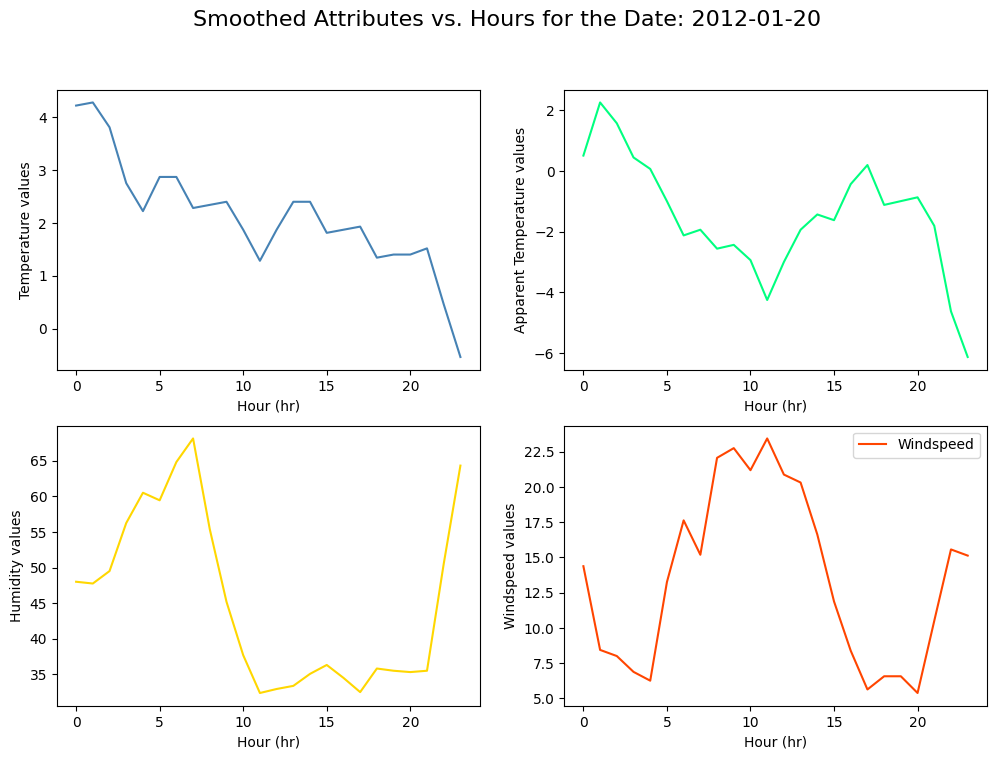

In [9]:
df_Smoothed = df6.copy()  # Make a copy of the DataFrame to avoid modifying the original

# The Savitzky-Golay Smoothing filter
window_size = 4  # Window size for the filter
poly_order = 3   # Polynomial order for fitting

df_Smoothed['temp']      = savgol_filter(df6['temp'], window_size, poly_order)
df_Smoothed['atemp']     = savgol_filter(df6['atemp'], window_size, poly_order)
df_Smoothed['hum']       = savgol_filter(df6['hum'], window_size, poly_order)
df_Smoothed['windspeed'] = savgol_filter(df6['windspeed'], window_size, poly_order)

df_Smoothed['temp']      = df_Smoothed['temp'].round(3)
df_Smoothed['atemp']     = df_Smoothed['atemp'].round(3)
df_Smoothed['hum']       = df_Smoothed['hum'].abs().round(3)
df_Smoothed['windspeed'] = df_Smoothed['windspeed'].abs().round(3)



df_selected = df_Smoothed[df_Smoothed['dteday'] == random_date]


fig1, axs1 = plt.subplots(2, 2, figsize=(12, 8))
fig1.suptitle(f"Smoothed Attributes vs. Hours for the Date: {random_date}", fontsize=16)

# Iterate over each subplot
for i, ax in enumerate(axs1.flat):
    color = colors[i]
    attr = attr_list[i]
    ax.plot(df_selected['hr'], df_selected[attr], color=color, label=attr_name_list[i])

    ax.set_ylabel(f"{attr_name_list[i]} values")
    ax.set_xlabel('Hour (hr)')

plt.legend()
plt.show()

fig1.savefig('../images/attributes_vs_hours_Smoothed.png', dpi=300, bbox_inches='tight')

#### Step 6-2: Assessing the independence of attributes:

Additionally, it is crucial to evaluate the independence of attributes such as 'temp' and 'atemp'. Independence between these attributes ensures that they provide unique and distinct information. If there is a high degree of correlation or dependence between these attributes, it might lead to redundancy in the data. In such cases, it is necessary to measure them independently to capture diverse aspects of the system or phenomenon under study.


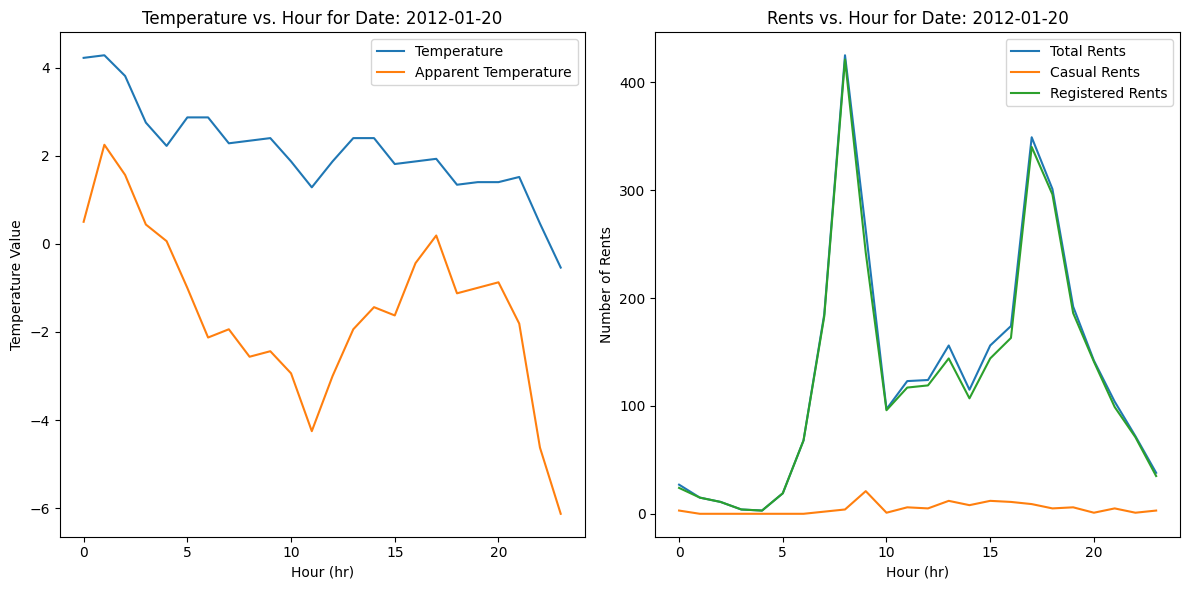

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot - Temperature vs. Hour
axs[0].plot(df_selected['hr'], df_selected['temp'], label='Temperature')
axs[0].plot(df_selected['hr'], df_selected['atemp'], label='Apparent Temperature')

axs[0].set_xlabel('Hour (hr)')
axs[0].set_ylabel('Temperature Value')
axs[0].set_title(f"Temperature vs. Hour for Date: {random_date}")
axs[0].legend()

# Second subplot - Rents vs. Hour
axs[1].plot(df_selected['hr'], df_selected['cnt'], label='Total Rents')
axs[1].plot(df_selected['hr'], df_selected['casual'], label='Casual Rents')
axs[1].plot(df_selected['hr'], df_selected['registered'], label='Registered Rents')

axs[1].set_xlabel('Hour (hr)')
axs[1].set_ylabel('Number of Rents')
axs[1].set_title(f"Rents vs. Hour for Date: {random_date}")

axs[1].legend()
fig.tight_layout()
plt.show()

fig.savefig('../images/similar_attributes_Aday.png', dpi=300, bbox_inches='tight')



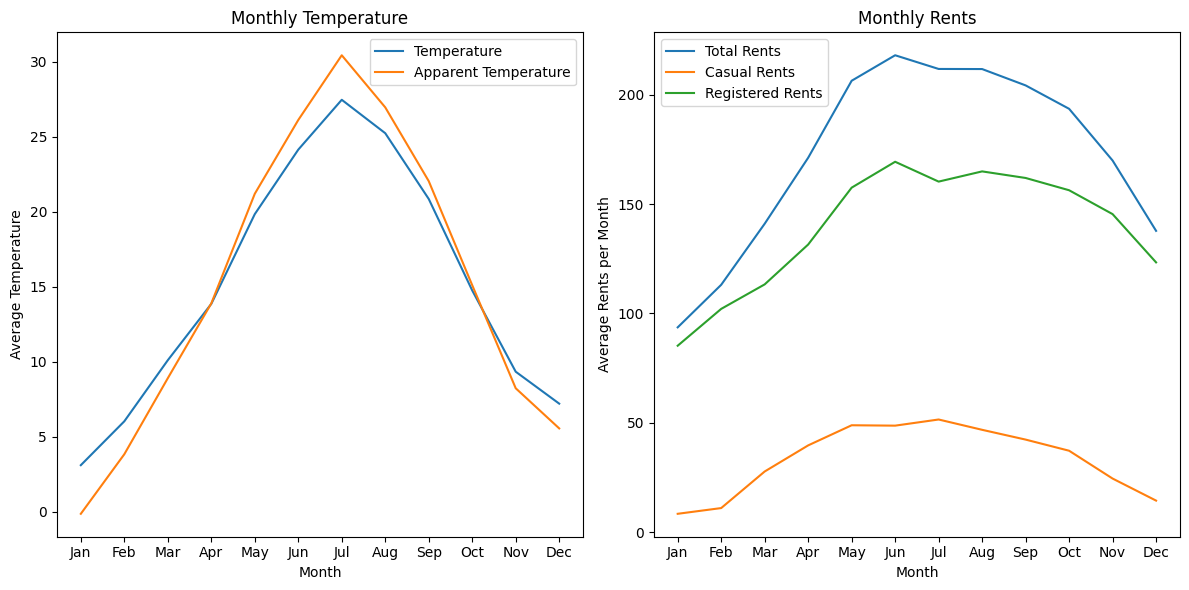

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

df_avg = df_Smoothed.groupby('mnth').mean(numeric_only=True)
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# First subplot - Temperature vs. Hour
axs[0].plot(df_avg.index, df_avg['temp'], label='Temperature')
axs[0].plot(df_avg.index, df_avg['atemp'], label='Apparent Temperature')

axs[0].set_title('Monthly Temperature')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Average Temperature')
axs[0].set_xticks(range(1, 13))
axs[0].set_xticklabels(month_list)
axs[0].legend()

# Second subplot - Rents vs. Hour
axs[1].plot(df_avg.index, df_avg['cnt'],        label='Total Rents')
axs[1].plot(df_avg.index, df_avg['casual'],     label='Casual Rents')
axs[1].plot(df_avg.index, df_avg['registered'], label='Registered Rents')

axs[1].set_title('Monthly Rents')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Average Rents per Month')
axs[1].set_xticks(range(1, 13))
axs[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[1].legend()


fig.tight_layout()
plt.show()

fig.savefig('../images/similar_attributes_Ayear.png', dpi=300, bbox_inches='tight')

Based on the observed figures, it can be concluded that the attributes 'temp' and 'atemp' exhibit a strong correlation both over the course of a day and throughout the year. Similarly, the attributes 'cnt', 'registered' and 'casual' also display a significant correlation. Therefore, these attribute will be ignored to avoid redundant information.

In [12]:
df_non_Smoothed = df6.copy()
df_non_Smoothed.drop(['atemp', 'casual', 'registered'], axis=1, inplace=True)

df_Smoothed_ = df_Smoothed.copy()
df_Smoothed_.drop(['atemp', 'casual', 'registered'], axis=1, inplace=True)

df_Smoothed_.head()
#df_non_Smoothed.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,3.280,81.000,0.000,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,2.340,80.000,0.000,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,2.810,77.500,0.000,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,3.339,74.687,0.375,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,3.339,74.687,3.377,1


#### Step 6-3: Furture exploring the recorded data over period of a year

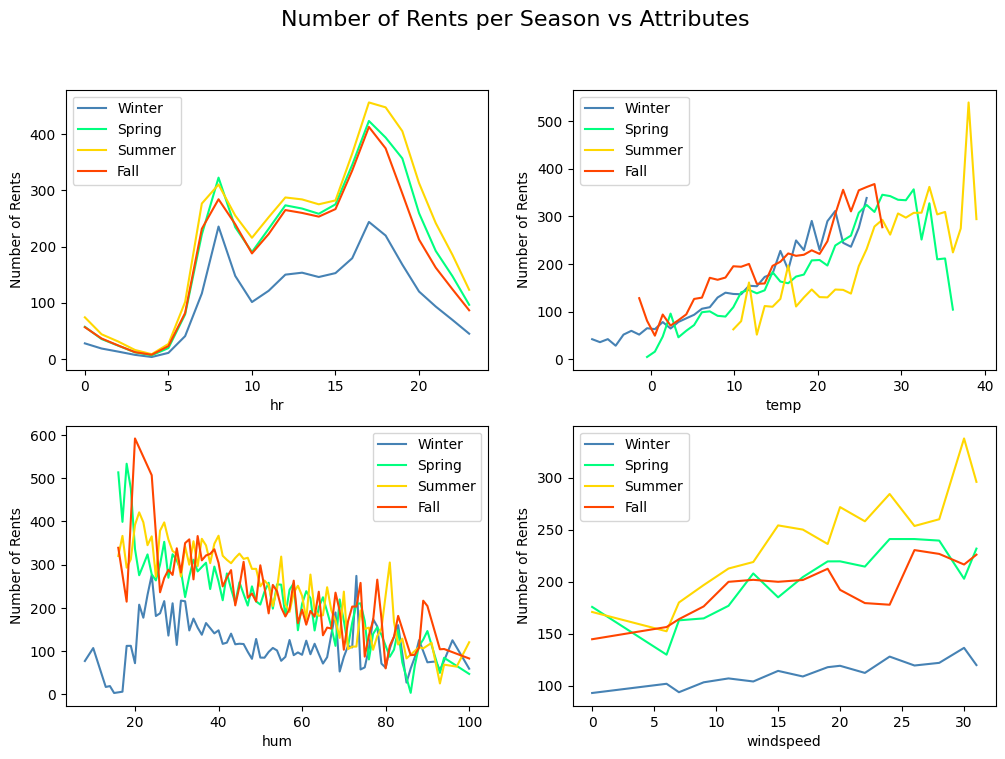

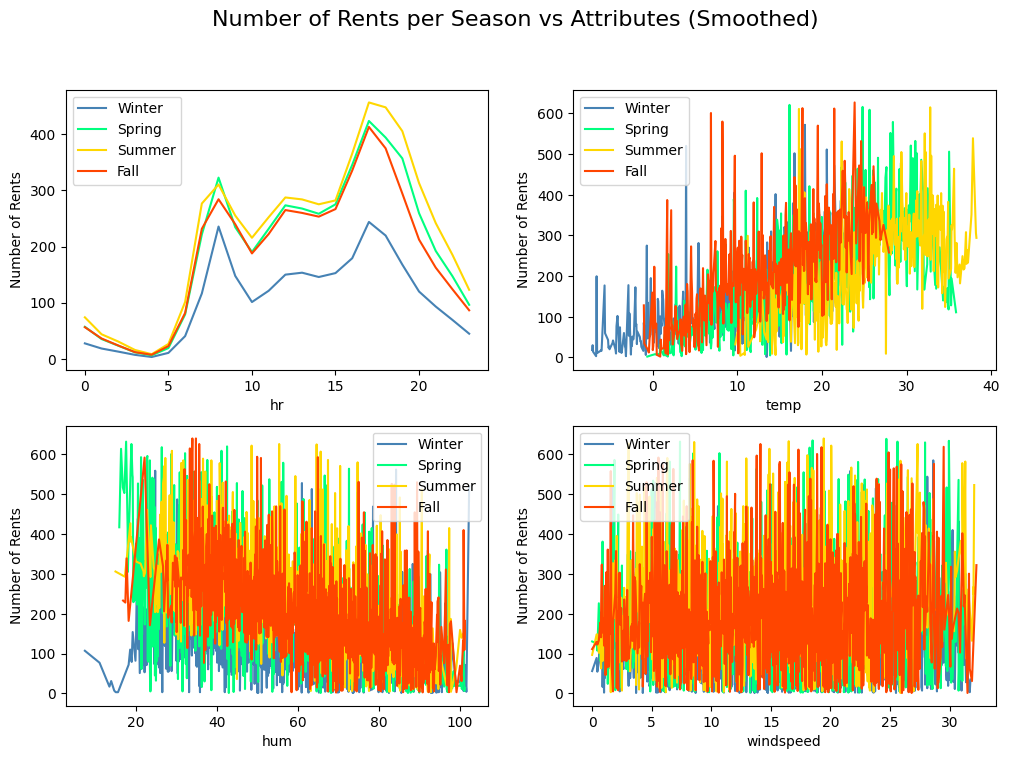

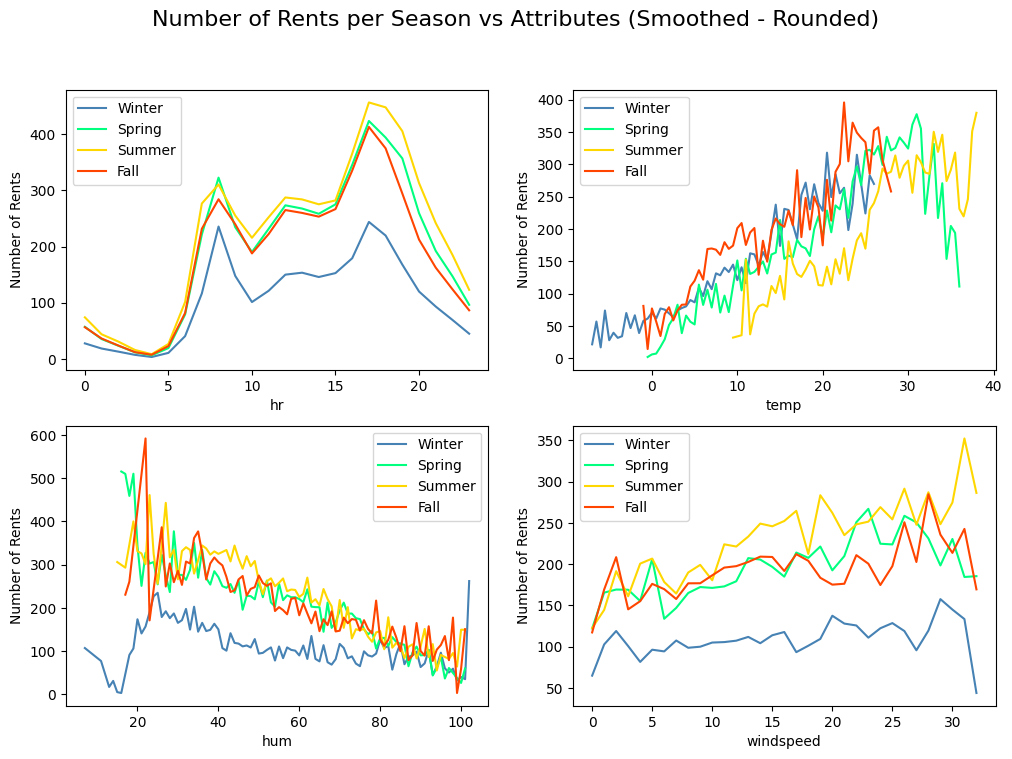

In [13]:
#instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
# setting colors
from KDD_f1 import plot_Rents_vs_Season_Attributes

df_Smoothed_rounded = df_Smoothed_.copy()
df_Smoothed_rounded['temp'] = np.round(df_Smoothed_['temp'] * 2) / 2
df_Smoothed_rounded['hum'] = np.round(df_Smoothed_['hum'])
df_Smoothed_rounded['windspeed'] = np.round(df_Smoothed_['windspeed'])


plot_Rents_vs_Season_Attributes(df_non_Smoothed, '')
plot_Rents_vs_Season_Attributes(df_Smoothed_, ' (Smoothed)')
plot_Rents_vs_Season_Attributes(df_Smoothed_rounded, ' (Smoothed - Rounded)')


# df_non_Smoothed, df_Smoothed_, df_Smoothed_rounded

#### Step 7: Data Balancing:
Displaying the dataset at step-4 (df4) following the treatment of missing values and removal of duplicated entries.

number of instances:  17379


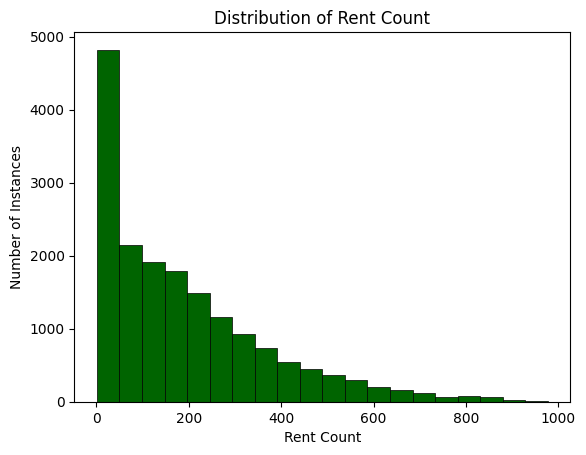

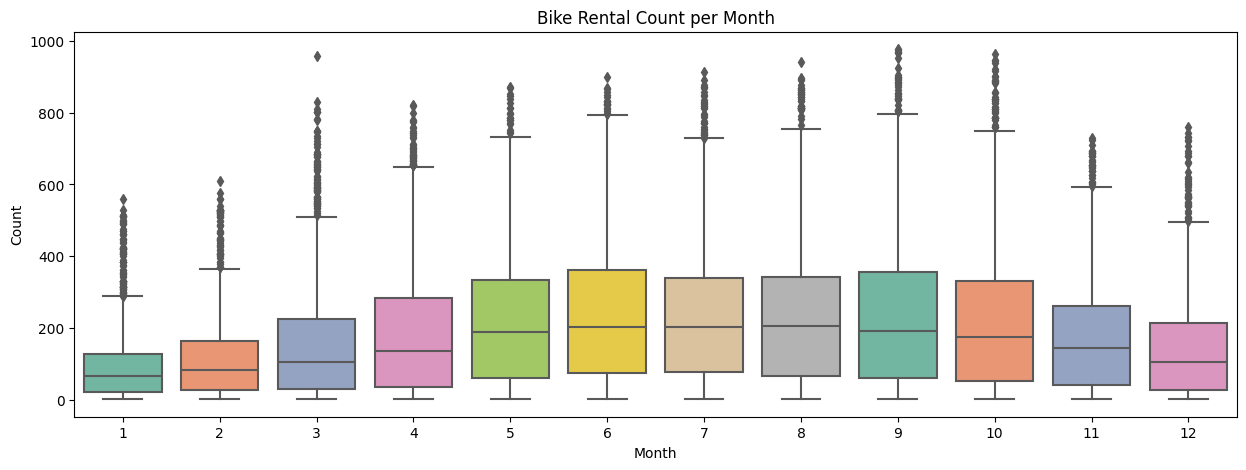

In [14]:
# Displaying data at step-4 (df4)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("number of instances: ", df4.shape[0])

# Plotting a histogram of 'cnt' column from the DataFrame 'df'
plt.hist(df4['cnt'], color='darkgreen', bins=20, edgecolor='black', linewidth=0.5)
plt.xlabel('Rent Count')
plt.ylabel('Number of Instances')
plt.title ('Distribution of Rent Count')
plt.show()

# Visualizing bike usage per month.
plt.figure(figsize=(15, 5))
sns.boxplot(x='mnth', y='cnt', data=df4, palette='Set2')
plt.title('Bike Rental Count per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

number of instances:  16522


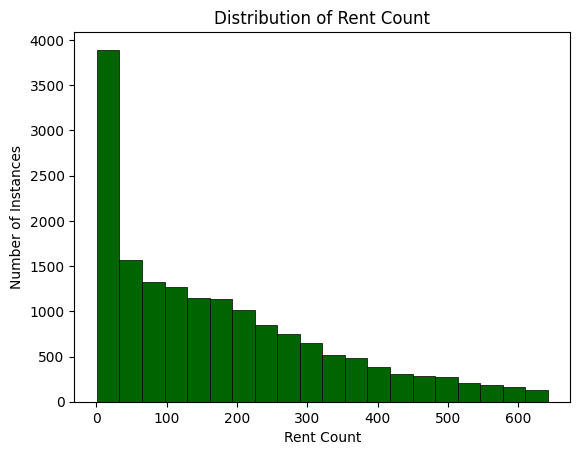

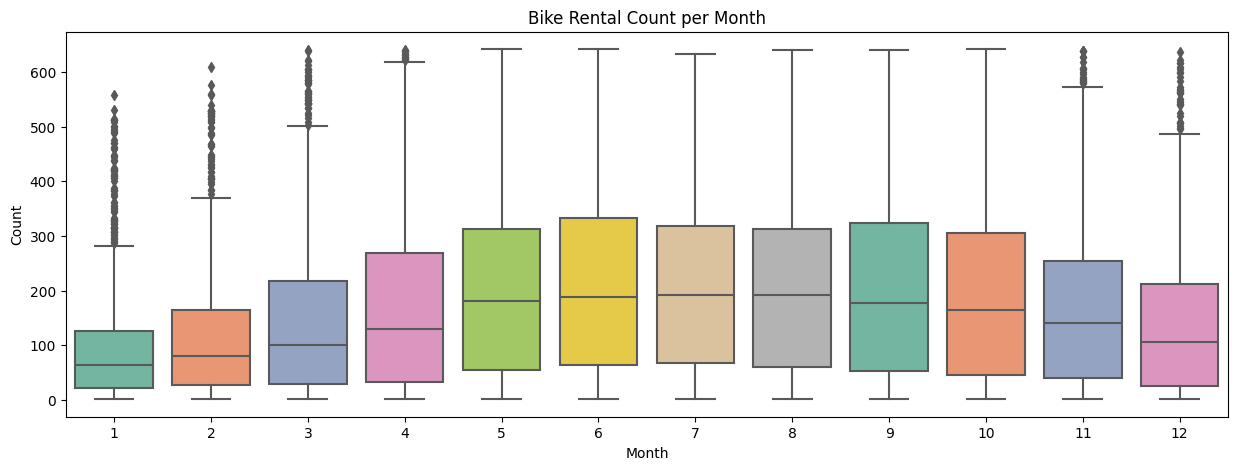

In [15]:
# Displaying data at step-6-3 (df_Smoothed_rounded)

print("number of instances: ", df_Smoothed_rounded.shape[0])

# Plotting a histogram of 'cnt' column from the DataFrame 'df'
plt.hist(df_Smoothed_rounded['cnt'], color='darkgreen', bins=20, edgecolor='black', linewidth=0.5)
plt.xlabel('Rent Count')
plt.ylabel('Number of Instances')
plt.title ('Distribution of Rent Count')
plt.show()

# Visualizing usage of bike per month.
plt.figure(figsize=(15, 5))
sns.boxplot(x='mnth', y='cnt', data=df_Smoothed_rounded, palette='Set2')
plt.title('Bike Rental Count per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

Our data exhibits an evident imbalance, prompting the adoption of two solutions to address this issue.

##### a) Oversampling
In this instance, we employed the Oversampling function sourced from the file 'KDD_f1.py' and utilized the RandomOverSampler from the 'imblearn.over_sampling' library to address the disparity between the number of underrepresented samples and rents.

number of instances:  164480


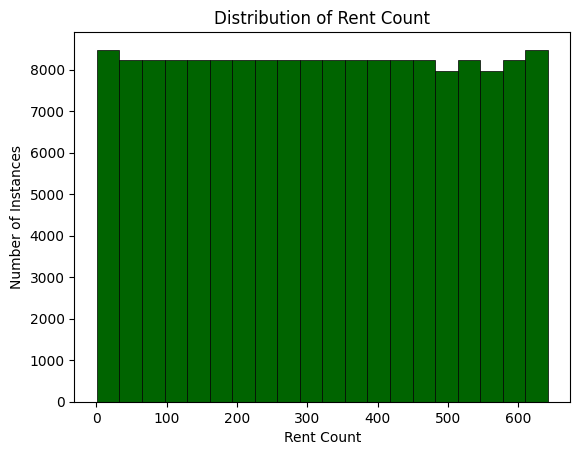

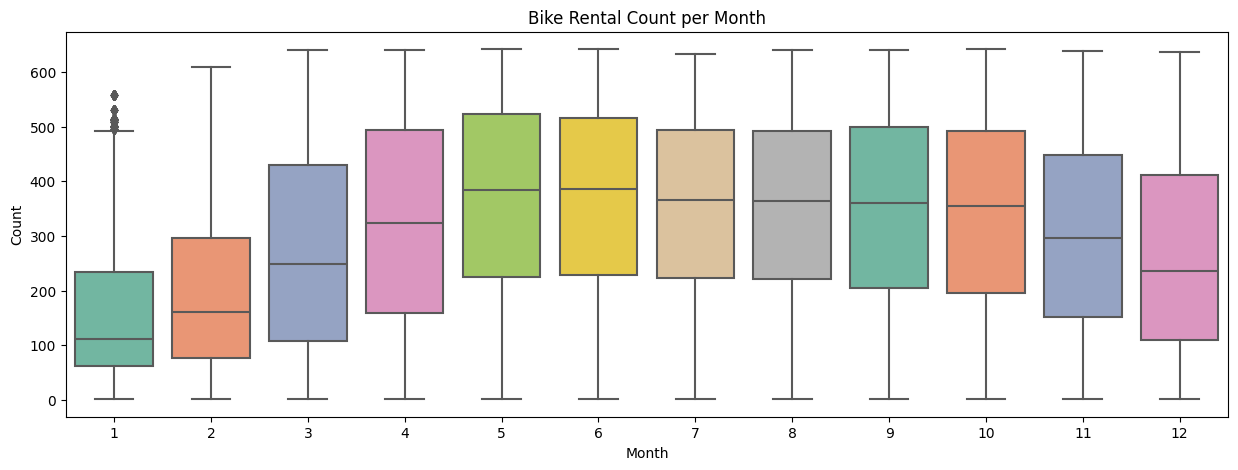

In [16]:
# Blancing target attribute
from KDD_f1 import balance_data_oversampler

df_nsb_os  = balance_data_oversampler(df_non_Smoothed)
df_sb_os   = balance_data_oversampler(df_Smoothed_)
df_srb_os  = balance_data_oversampler(df_Smoothed_rounded)

print("number of instances: ", df_nsb_os.shape[0])

# Plotting a histogram of 'cnt' column from the DataFrame 'df'
plt.hist(df_nsb_os['cnt'], color='darkgreen', bins=20, edgecolor='black', linewidth=0.5)
plt.xlabel('Rent Count')
plt.ylabel('Number of Instances')
plt.title ('Distribution of Rent Count')
plt.show()

# Visualizing usage of bike per month.
plt.figure(figsize=(15, 5))
sns.boxplot(x='mnth', y='cnt', data=df_sb_os, palette='Set2')
plt.title('Bike Rental Count per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

##### b) Undersampling

In this instance, we employed the Undersampling function sourced from the file 'KDD_f1.py' and utilized the RandomUnderSampler from the 'imblearn.under_sampling' library to address the disparity between the number of underrepresented samples and rents.

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   hum  windspeed  cnt  
0           1  3.28  81.0        0.0   16  
1           1  2.34  80.0        0.0   40  
2           1  2.34  80.0        0.0   32  
3           1  3.28  75.0        0.0   13  
4           1  3.28  75.0        0.0    1  


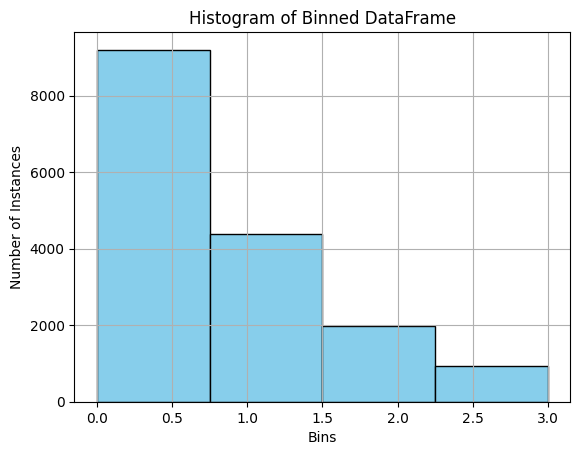

ValueError: With under-sampling methods, the number of samples in a class should be less or equal to the original number of samples. Originally, there is 1978 samples and 3780 samples are asked.

In [17]:
# Blancing target attribute
import matplotlib.pyplot as plt
from KDD_f1 import balance_data_undersampler
from KDD_f1 import balance_data_nearmiss

print(df_non_Smoothed.head(5))


df_nsb_us  = balance_data_undersampler(df_non_Smoothed)
df_sb_us   = balance_data_undersampler(df_Smoothed_)
df_srb_us  = balance_data_undersampler(df_Smoothed_rounded)

print("number of instances: ", df_nsb_us.shape[0])
print("number of instances: ", df_sb_us.shape[0])
print("number of instances: ", df_srb_us.shape[0])


# df_non_Smoothed, df_Smoothed_, df_Smoothed_rounded
# Plotting a histogram of 'cnt' column from the DataFrame 'df'
plt.hist(df_nsb_us['cnt'], color='darkgreen', bins=6, edgecolor='black', linewidth=0.5)
plt.xlabel('Rent Count')
plt.ylabel('Number of Instances')
plt.title ('Distribution of Rent Count')
plt.show()




print("number of instances: ", df_nsb_us.shape[0])
print("number of instances: ", df_sb_us.shape[0])
print("number of instances: ", df_srb_us.shape[0])

plot_Rents_vs_Season_Attributes(df_nsb_us, 'Balanced-undersample')
plot_Rents_vs_Season_Attributes(df_sb_us, ' (Balanced-undersample-Smoothed)')
plot_Rents_vs_Season_Attributes(df_srb_us, ' (Balanced-undersample-Smoothed-Rounded)')

#### Step 8: Saving Datasets

In [ ]:
from KDD_f1 import save_dataframe

df  = save_dataframe(df_non_Smoothed, 'original')
df_s   = save_dataframe(df_Smoothed_, 'S')
df_sr  = save_dataframe(df_Smoothed_rounded, 'SR')

df_nsbos_norm = save_dataframe(df_nsb_os, 'bal_over')
df_sbos_norm = save_dataframe(df_sb_os, 'S_bal_over')
df_srbos_norm = save_dataframe(df_srb_os, 'SR_bal_over')

df_nsbus_norm = save_dataframe(df_nsb_us,  'bal_under')
df_sbus_norm = save_dataframe(df_sb_us,  'S_bal_under')
df_srbus_norm = save_dataframe(df_srb_us,  'SR_bal_under')

In [ ]:
data = df5
data = pd.get_dummies(data, columns = ['season','weathersit','mnth','weekday'],drop_first=True)

data['cnt_lag_1'] = data['cnt'].shift(-1)
data['cnt_lag_2'] = data['cnt'].shift(-2)
data = data.dropna()

data.drop(['instant', 'dteday', 'atemp', 'casual', 'registered'], axis=1, inplace=True)

data.head()



,yr,hr,holiday,workingday,temp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,cnt_lag_1,cnt_lag_2
0,0,0,0,0,0.24,0.81,0.0,16,0,0,...,0,0,0,0,0,0,0,1,40.0,32.0
1,0,1,0,0,0.22,0.80,0.0,40,0,0,...,0,0,0,0,0,0,0,1,32.0,13.0
2,0,2,0,0,0.22,0.80,0.0,32,0,0,...,0,0,0,0,0,0,0,1,13.0,1.0
3,0,3,0,0,0.24,0.75,0.0,13,0,0,...,0,0,0,0,0,0,0,1,1.0,1.0
4,0,4,0,0,0.24,0.75,0.0,1,0,0,...,0,0,0,0,0,0,0,1,1.0,2.0
